1. Preparação dos dados:



*   Upload do ZIP
*   Construção da Estrutura de diretórios
*   Divisão dos dados
*   Pré-processamento:
Redimensiona todas as imagens para 150x150 pixels,
Aplica aumento de dados (data augmentation) apenas no conjunto de treino,
Normaliza os valores dos pixels para [0,1]





In [ ]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
import os
import zipfile

# 1. Extraindo o arquivo ZIP corretamente (com aspas ou escape nos espaços)
!unzip "dogs vs cats.zip" -d extracted_data

# 2. Verificando a estrutura de diretórios extraída
print("Conteúdo após extração:")
print(os.listdir("extracted_data"))



Archive:  dogs vs cats.zip
   creating: extracted_data/dogs vs cats/
   creating: extracted_data/dogs vs cats/test/
  inflating: extracted_data/dogs vs cats/test/1.jpg  
  inflating: extracted_data/dogs vs cats/test/10.jpg  
  inflating: extracted_data/dogs vs cats/test/100.jpg  
  inflating: extracted_data/dogs vs cats/test/11.jpg  
  inflating: extracted_data/dogs vs cats/test/12.jpg  
  inflating: extracted_data/dogs vs cats/test/13.jpg  
  inflating: extracted_data/dogs vs cats/test/14.jpg  
  inflating: extracted_data/dogs vs cats/test/15.jpg  
  inflating: extracted_data/dogs vs cats/test/16.jpg  
  inflating: extracted_data/dogs vs cats/test/17.jpg  
  inflating: extracted_data/dogs vs cats/test/18.jpg  
  inflating: extracted_data/dogs vs cats/test/19.jpg  
  inflating: extracted_data/dogs vs cats/test/2.jpg  
  inflating: extracted_data/dogs vs cats/test/20.jpg  
  inflating: extracted_data/dogs vs cats/test/21.jpg  
  inflating: extracted_data/dogs vs cats/test/22.jpg  
  inf

In [ ]:
# Verificando se já existe a estrutura correta
if 'dogs vs cats' in os.listdir():
    base_dir = 'dogs vs cats'
else:
    base_dir = '.'  # Usa o diretório atual se não estiver em subpasta


In [ ]:
import os

# Caminho até a pasta 'train' onde estão os dados originais
base_dir = "/content/extracted_data/dogs vs cats"
train_path = os.path.join(base_dir, 'train')  # /content/extracted_data/dogs vs cats/train

# Verifique se os diretórios existem
print(os.listdir(train_path))  # Deve retornar ['cats', 'dogs']



['cats', 'dogs']


In [ ]:
cat_files = os.listdir(os.path.join(train_path, 'cats'))
dog_files = os.listdir(os.path.join(train_path, 'dogs'))

print(f"Total de gatos: {len(cat_files)}")
print(f"Total de cachorros: {len(dog_files)}")


Total de gatos: 500
Total de cachorros: 500


In [ ]:
from sklearn.model_selection import train_test_split
import shutil

# Divisão para gatos
cat_train, cat_temp = train_test_split(cat_files, test_size=0.3, random_state=42)
cat_val, cat_test = train_test_split(cat_temp, test_size=0.5, random_state=42)

# Divisão para cachorros
dog_train, dog_temp = train_test_split(dog_files, test_size=0.3, random_state=42)
dog_val, dog_test = train_test_split(dog_temp, test_size=0.5, random_state=42)


In [ ]:
# Criar a estrutura: train_final, validation, test
final_base = "/content/dataset_final"

folders = ['train_final/cats', 'train_final/dogs',
           'validation/cats', 'validation/dogs',
           'test/cats', 'test/dogs']

for folder in folders:
    os.makedirs(os.path.join(final_base, folder), exist_ok=True)


In [ ]:
def move_files(file_list, source_dir, target_dir):
    for fname in file_list:
        shutil.copy(os.path.join(source_dir, fname), os.path.join(target_dir, fname))  # copy para manter backup


In [ ]:
# CATS
move_files(cat_train, os.path.join(train_path, 'cats'), os.path.join(final_base, 'train_final/cats'))
move_files(cat_val,   os.path.join(train_path, 'cats'), os.path.join(final_base, 'validation/cats'))
move_files(cat_test,  os.path.join(train_path, 'cats'), os.path.join(final_base, 'test/cats'))

# DOGS
move_files(dog_train, os.path.join(train_path, 'dogs'), os.path.join(final_base, 'train_final/dogs'))
move_files(dog_val,   os.path.join(train_path, 'dogs'), os.path.join(final_base, 'validation/dogs'))
move_files(dog_test,  os.path.join(train_path, 'dogs'), os.path.join(final_base, 'test/dogs'))


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Caminhos para os diretórios de treino e validação
train_dir = '/content/dataset_final/train_final'
val_dir = '/content/dataset_final/validation'

# Pré-processamento das imagens com aumento de dados
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)


In [ ]:
# Geradores de dados
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary'
)

Found 700 images belonging to 2 classes.
Found 150 images belonging to 2 classes.


In [ ]:
# Diretório com os dados de teste
test_dir = '/content/dataset_final/test'

# Gerador de dados para teste (sem augmentação, apenas normalização)
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary',
    shuffle=False  # importante para avaliação e predição
)

Found 150 images belonging to 2 classes.


In [ ]:
# Verificando balanceamento
class_counts = np.bincount(train_generator.classes)
print(f"Distribuição de classes: {class_counts}")

Distribuição de classes: [350 350]


In [ ]:
# Calculando class_weight
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = dict(enumerate(class_weights))
print(f"Pesos calculados para as classes: {class_weights_dict}")

Pesos calculados para as classes: {0: np.float64(1.0), 1: np.float64(1.0)}


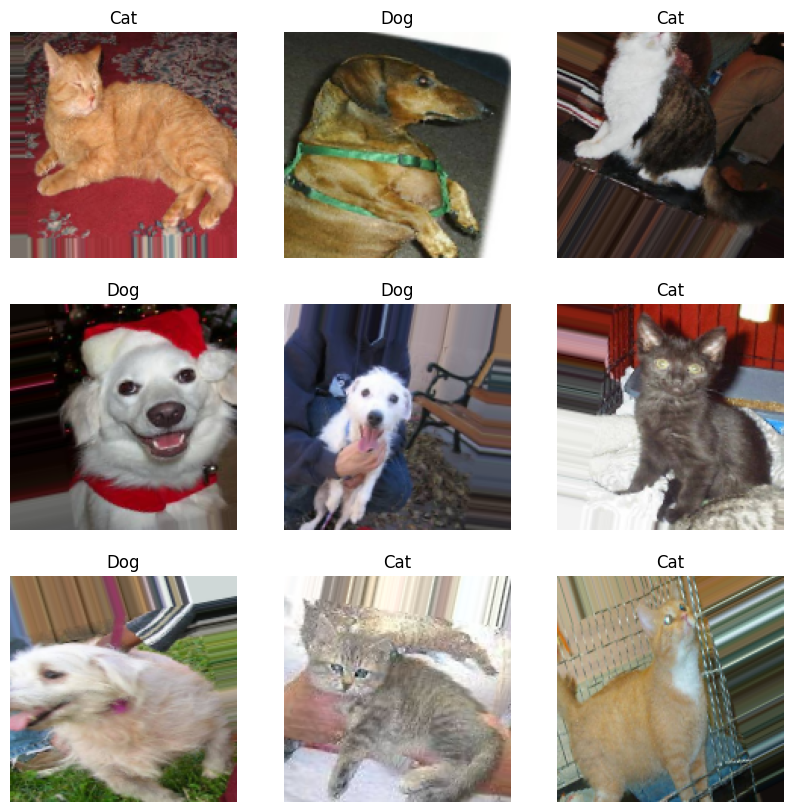

In [ ]:
import matplotlib.pyplot as plt

def plot_images(generator):
    plt.figure(figsize=(10, 10))
    images, labels = next(generator)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title("Dog" if labels[i] == 1 else "Cat")
        plt.axis("off")
    plt.show()

plot_images(train_generator)


2. Construção e treinamento de uma CNN:


*    Arquitetura CNN: 2 camadas convolucionais com fução de ativação Relu, 2 camadas de pooling, 1 camada Flatten e 2 camadas densas uma com fuções de ativação Relu e  Sigmoid respectivamente.

*   Input shape: 64x64x3

*    Compilação: adam, binary_crossentropy, accuracy.
*   Treinamento: 15 épocas com steps_per_epoch = len(train_generator) e validation_steps = len(val_generator)
*   Salvamento: Modelo salvo no formato .h5 para uso futuro




In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Construção da CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),

    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [ ]:
# Compilação do modelo
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Treinamento
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=15,
    validation_data=val_generator,
    validation_steps=len(val_generator)
)

Epoch 1/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 0.5135 - loss: 0.7235 - val_accuracy: 0.5400 - val_loss: 0.6908
Epoch 2/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - accuracy: 0.5298 - loss: 0.6920 - val_accuracy: 0.5200 - val_loss: 0.6879
Epoch 3/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.5214 - loss: 0.6884 - val_accuracy: 0.4800 - val_loss: 0.6968
Epoch 4/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - accuracy: 0.5415 - loss: 0.6892 - val_accuracy: 0.5333 - val_loss: 0.6828
Epoch 5/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.5768 - loss: 0.6719 - val_accuracy: 0.5733 - val_loss: 0.6732
Epoch 6/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - accuracy: 0.6110 - loss: 0.6667 - val_accuracy: 0.6000 - val_loss: 0.6776
Epoch 7/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 0.6771 - loss: 0.6276 - val_accuracy: 0.6400 - val_loss: 0.6284
Epoch 8/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 0.6423 - loss: 0.6337 - val_accuracy: 0.6133 -

In [ ]:
# Salvando o modelo treinado
model.save('dogs_vs_cats_cnn_retreinado.h5')

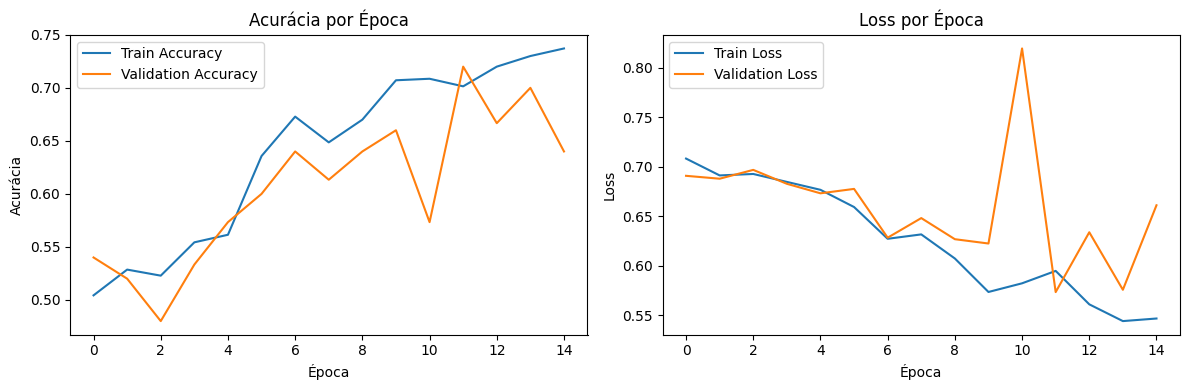

In [ ]:
# Plotando os gráficos de treinamento
def plot_training_history(history):
    # Acurácia
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Acurácia por Época')
    plt.xlabel('Época')
    plt.ylabel('Acurácia')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss por Época')
    plt.xlabel('Época')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [ ]:
# Avaliação no conjunto de teste
print("\nAvaliação no conjunto de teste:")
test_loss, test_acc = model.evaluate(test_generator)
print(f"Acurácia no teste: {test_acc:.4f}")
print(f"Loss no teste: {test_loss:.4f}")



Avaliação no conjunto de teste:
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5570 - loss: 0.7999
Acurácia no teste: 0.6800
Loss no teste: 0.6141


3. Avaliação e testes

 Avaliação Quantitativa:


*   Relatório de Classificação: Mostra precisão, recall e F1-Score para cada classe
    - Precisão: Proporção de predições corretas para cada classe
    - Recall: Proporção de casos reais identificados corretamente
    - F1-Score: Média harmônica entre precisão e recall
*   Matriz de Confusão: Visualização dos acertos e erros por classe

Teste com Novas Imagens:

*  A função predict_new_image:
    - Carrega e pré-processa a imagem no mesmo formato do treino
    - Faz a predição e mostra a imagem com o resultado
    - Exibe a confiança da predição em porcentagem



In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Avaliação detalhada no conjunto de teste:
test_generator.reset()
y_pred = model.predict(test_generator, steps=len(test_generator))
y_pred = (y_pred > 0.5).astype(int)

y_true = test_generator.classes

# Métricas detalhadas
print("\nRelatório de Classificação:")
print(classification_report(y_true, y_pred, target_names=['Cats', 'Dogs']))

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step

Relatório de Classificação:
              precision    recall  f1-score   support

        Cats       0.89      0.41      0.56        75
        Dogs       0.62      0.95      0.75        75

    accuracy                           0.68       150
   macro avg       0.75      0.68      0.66       150
weighted avg       0.75      0.68      0.66       150



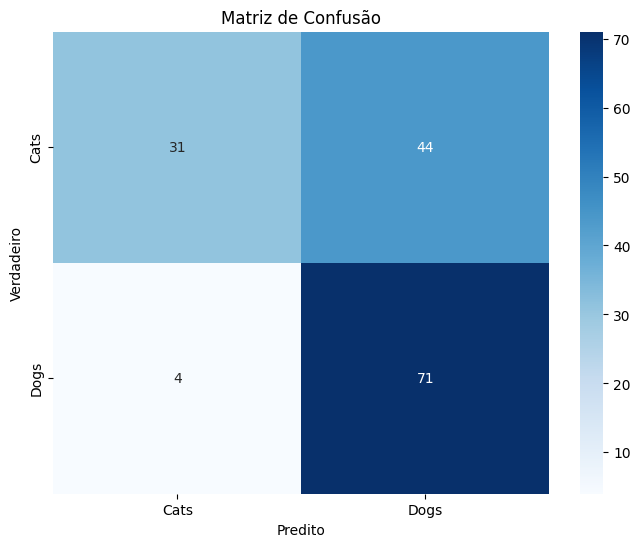

In [ ]:
# Matriz de Confusão
conf_mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Cats', 'Dogs'],
            yticklabels=['Cats', 'Dogs'])
plt.title('Matriz de Confusão')
plt.ylabel('Verdadeiro')
plt.xlabel('Predito')
plt.show()

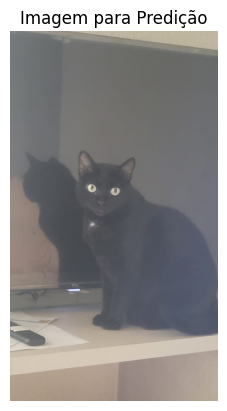

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Caminho da imagem de teste
img_path = '/content/test_cat (3).jpeg'

# Carregar e exibir a imagem
img = Image.open(img_path)
plt.imshow(img)
plt.axis('off')
plt.title('Imagem para Predição')
plt.show()


In [ ]:
# Realizar a predição
prediction = model.predict(img_array)

# Interpretar resultado
if prediction[0][0] > 0.5:
    print(f"Predição: Cachorro 🐶 (probabilidade: {prediction[0][0]:.4f})")
else:
    print(f"Predição: Gato 🐱 (probabilidade: {1 - prediction[0][0]:.4f})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predição: Gato 🐱 (probabilidade: 0.8297)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


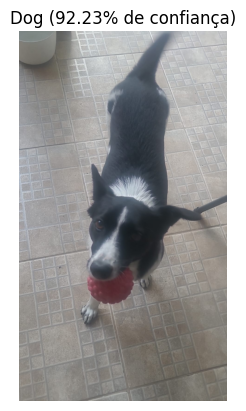

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Caminho da imagem de teste
img_path = '/content/test_dog (7).jpeg'

# Carregar a imagem
img = Image.open(img_path)

# Pré-processamento da imagem
img_resized = img.resize((64, 64))  # Redimensionar para o tamanho da CNN
img_array = image.img_to_array(img_resized)  # Converter para array
img_array = img_array / 255.0  # Normalizar os pixels
img_array = np.expand_dims(img_array, axis=0)  # Adicionar dimensão de batch

# Realizar a predição
prediction = model.predict(img_array)

# Interpretar e exibir o resultado
if prediction[0][0] > 0.5:
    label = f"Dog ({prediction[0][0]*100:.2f}% de confiança)"
else:
    label = f"Cat ({(1 - prediction[0][0])*100:.2f}% de confiança)"

# Exibir a imagem com o rótulo como título
plt.imshow(img)
plt.axis('off')
plt.title(label)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


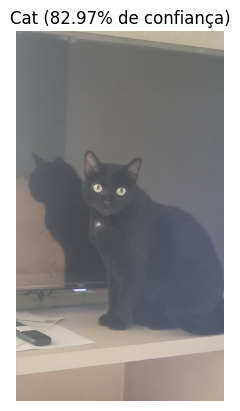

In [ ]:
# Caminho da imagem de teste
img_path = '/content/test_cat (3).jpeg'

# Carregar a imagem
img = Image.open(img_path)

# Pré-processamento da imagem
img_resized = img.resize((64, 64))  # Redimensionar para o tamanho da CNN
img_array = image.img_to_array(img_resized)  # Converter para array
img_array = img_array / 255.0  # Normalizar os pixels
img_array = np.expand_dims(img_array, axis=0)  # Adicionar dimensão de batch

# Realizar a predição
prediction = model.predict(img_array)

# Interpretar e exibir o resultado
if prediction[0][0] > 0.5:
    label = f"Dog ({prediction[0][0]*100:.2f}% de confiança)"
else:
    label = f"Cat ({(1 - prediction[0][0])*100:.2f}% de confiança)"

# Exibir a imagem com o rótulo como título
plt.imshow(img)
plt.axis('off')
plt.title(label)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


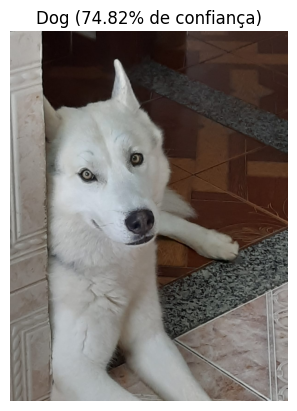

In [ ]:
# Caminho da imagem de teste
img_path = '/content/test_dog (3).jpeg'

# Carregar a imagem
img = Image.open(img_path)

# Pré-processamento da imagem
img_resized = img.resize((64, 64))  # Redimensionar para o tamanho da CNN
img_array = image.img_to_array(img_resized)  # Converter para array
img_array = img_array / 255.0  # Normalizar os pixels
img_array = np.expand_dims(img_array, axis=0)  # Adicionar dimensão de batch

# Realizar a predição
prediction = model.predict(img_array)

# Interpretar e exibir o resultado
if prediction[0][0] > 0.5:
    label = f"Dog ({prediction[0][0]*100:.2f}% de confiança)"
else:
    label = f"Cat ({(1 - prediction[0][0])*100:.2f}% de confiança)"

# Exibir a imagem com o rótulo como título
plt.imshow(img)
plt.axis('off')
plt.title(label)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


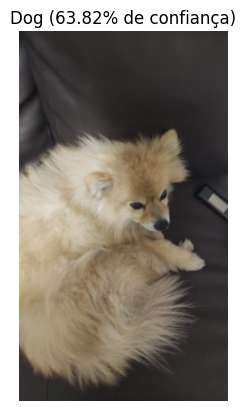

In [ ]:
# Caminho da imagem de teste
img_path = '/content/test_dog (4).jpeg'

# Carregar a imagem
img = Image.open(img_path)

# Pré-processamento da imagem
img_resized = img.resize((64, 64))  # Redimensionar para o tamanho da CNN
img_array = image.img_to_array(img_resized)  # Converter para array
img_array = img_array / 255.0  # Normalizar os pixels
img_array = np.expand_dims(img_array, axis=0)  # Adicionar dimensão de batch

# Realizar a predição
prediction = model.predict(img_array)

# Interpretar e exibir o resultado
if prediction[0][0] > 0.5:
    label = f"Dog ({prediction[0][0]*100:.2f}% de confiança)"
else:
    label = f"Cat ({(1 - prediction[0][0])*100:.2f}% de confiança)"

# Exibir a imagem com o rótulo como título
plt.imshow(img)
plt.axis('off')
plt.title(label)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


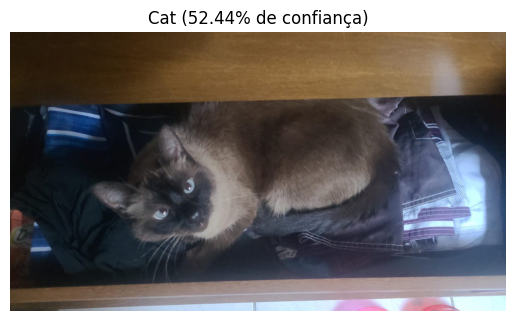

In [ ]:
# Caminho da imagem de teste
img_path = '/content/test_cat_hannah.jpeg'

# Carregar a imagem
img = Image.open(img_path)

# Pré-processamento da imagem
img_resized = img.resize((64, 64))  # Redimensionar para o tamanho da CNN
img_array = image.img_to_array(img_resized)  # Converter para array
img_array = img_array / 255.0  # Normalizar os pixels
img_array = np.expand_dims(img_array, axis=0)  # Adicionar dimensão de batch

# Realizar a predição
prediction = model.predict(img_array)

# Interpretar e exibir o resultado
if prediction[0][0] > 0.5:
    label = f"Dog ({prediction[0][0]*100:.2f}% de confiança)"
else:
    label = f"Cat ({(1 - prediction[0][0])*100:.2f}% de confiança)"

# Exibir a imagem com o rótulo como título
plt.imshow(img)
plt.axis('off')
plt.title(label)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Text(0.5, 1.0, 'Cat (67.26% de confiança)')

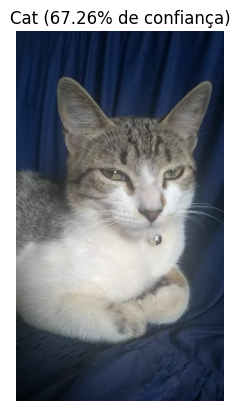

In [ ]:
# Caminho da imagem de teste
img_path = '/content/test_cat_Luke.jpeg'

# Carregar a imagem
img = Image.open(img_path)

# Pré-processamento da imagem
img_resized = img.resize((64, 64))  # Redimensionar para o tamanho da CNN
img_array = image.img_to_array(img_resized)  # Converter para array
img_array = img_array / 255.0  # Normalizar os pixels
img_array = np.expand_dims(img_array, axis=0)  # Adicionar dimensão de batch

# Realizar a predição
prediction = model.predict(img_array)

# Interpretar e exibir o resultado
if prediction[0][0] > 0.5:
    label = f"Dog ({prediction[0][0]*100:.2f}% de confiança)"
else:
    label = f"Cat ({(1 - prediction[0][0])*100:.2f}% de confiança)"

# Exibir a imagem com o rótulo como título
plt.imshow(img)
plt.axis('off')
plt.title(label)

In [ ]:
# Caminho da imagem de teste
img_path = '/content/test_cat_Luke.jpeg'

# Carregar a imagem
img = Image.open(img_path)

# Pré-processamento da imagem
img_resized = img.resize((64, 64))  # Redimensionar para o tamanho da CNN
img_array = image.img_to_array(img_resized)  # Converter para array
img_array = img_array / 255.0  # Normalizar os pixels
img_array = np.expand_dims(img_array, axis=0)  # Adicionar dimensão de batch

# Realizar a predição
prediction = model.predict(img_array)

# Interpretar e exibir o resultado
if prediction[0][0] > 0.5:
    label = f"Dog ({prediction[0][0]*100:.2f}% de confiança)"
else:
    label = f"Cat ({(1 - prediction[0][0])*100:.2f}% de confiança)"

# Exibir a imagem com o rótulo como título
plt.imshow(img)
plt.axis('off')
plt.title(label)